In [ ]:
import json, os, math, sys, random, re, pytz
from datetime import datetime
timezone = pytz.timezone('America/New_York') 
import torch
sys.path.append("../scripts/")
from causal_transformer.model import Causal_Transformer
from causal_transformer.config import *
from causal_transformer.dataset import sequences_collator
from causal_transformer.utils import get_acc

import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from datasets import concatenate_datasets
from datasets import load_dataset
from functools import partial
from collections import defaultdict, Counter
from pprint import pprint

In [5]:
device = "cuda"
task = "counting_samesymbol_addbigram"
config = eval(f"{task}_Config()")
ckpt_dir = "/data/yingshac/llms_do_math/scripts/causal_transformer/output"

load_from_dir = "0423_205349"
load_from_specific_epc = 10

load_from_config = json.load(open(os.path.join("../scripts/causal_transformer/output", load_from_dir, "config.json"), "r"))
for k in load_from_config:
    setattr(config, k, load_from_config[k])
if not "tie_word_embeddings" in load_from_config: config.tie_word_embeddings = False # for backward compatibility
model = Causal_Transformer(config)
model = model.to(device)

ckpt_dir = os.path.join(ckpt_dir, load_from_dir, "ckpts")
if load_from_specific_epc is None:
    load_from_pt = sorted(os.listdir(ckpt_dir), key=lambda x: int(x.split("_")[1]))[-1]
else:
    load_from_pt = sorted([x for x in os.listdir(ckpt_dir) if f"{load_from_specific_epc-1}_" in x[:4]], key=lambda x: int(x.split("_")[1]))[-1]
state_dict = torch.load(os.path.join(ckpt_dir, load_from_pt), map_location=device)
model.load_state_dict(state_dict, strict=False)
print(f"load from {load_from_pt}")



load from 9_343750_transformer.pt


In [6]:
print(model.wte.weight[60:64, 180])
print(model.lm_head.weight[60:64, 180])


tensor([-0.0090,  0.0336,  0.0754,  0.0996], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-0.2037, -0.2519, -0.2904, -0.2606], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [11]:
data_path = f"../data/rasp_primitives/{task}"
split = "ood_test"
test_data = load_dataset(
                    "text", 
                    data_files={split: f"{data_path}/{split}.txt"})
print(f"num {split} data = {len(test_data[split])}")

if config.absolute_posemb_shift or config.rotary_posemb_shift:
    augmentation = "shift"
elif config.absolute_posemb_rdmz or config.rotary_posemb_rdmz:
    augmentation = "randomized"
collator = partial(sequences_collator, 
                   w2i={w:i for i,w in enumerate(config.vocab)}, 
                   max_len=config.max_position_embeddings,
                   augmentation=augmentation,
                   )
test_dataloader = DataLoader(test_data[split], shuffle=False, batch_size=config.per_device_train_batch_size, collate_fn=collator)

num ood_test data = 50


In [12]:
counting_correct, counting_demo, last_correct, last_demo, correct, demo = 0, 0, 0, 0, 0, 0
test_losses = []

criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)

model.eval()
testing_output = {}

date = datetime.now(timezone).strftime("%m%d_%H%M%S")

k = 0
for i, batch in enumerate(test_dataloader):
    position_ids = None
    if batch['position_id'] is not None: position_ids = batch['position_id'].to(device)
    
    logits = model(
        batch['input_id'].to(device),
        position_ids = position_ids,
        attention_mask = batch['attention_mask'].to(device),
    )

    loss = criterion(
        logits.view(-1, logits.size(-1)), # bs*seq_len, vocab_size
        batch['label'].view(-1).to(device), # 1, bs*seq_len
    )
    test_losses.append(loss.detach().item())
    _counting_correct, _counting_demo, _last_correct, _last_demo = get_acc(logits.detach().cpu(), batch['label'].detach().cpu(), ignore_index=-1)
    counting_correct += _counting_correct
    counting_demo += _counting_demo
    last_correct += _last_correct
    last_demo += _last_demo
    correct += (_counting_correct + _last_correct)
    demo += (_counting_demo + _last_demo)
   
    for input_id, gth_id, pred_id in zip(batch['input_id'], batch['label'], logits.argmax(dim=-1)):
        input_seq = [config.vocab[i] for i in input_id if config.vocab[i]!='<pad>']
        gth_seq = [config.vocab[gth_id[i]] for i in range(len(gth_id)) if gth_id[i]!=-1]
        pred_seq = [config.vocab[pred_id[i]] for i in range(len(gth_id)) if gth_id[i]!=-1][:len(gth_seq)]
        testing_output[k] = {
            "input": " ".join(input_seq),
            "gth": " ".join(gth_seq),
            "pred": " ".join(pred_seq),
        }
        k+=1
    
print(f""" {split} acc
        | Test Loss: {round(np.mean(test_losses), 4)} 
        | Test Acc: {round(correct/demo, 4)} 
        | Test Counting Acc: {round(counting_correct/counting_demo, 4)} 
        | Test Last Acc: {round(last_correct/last_demo, 4)}
    """)

 ood_test acc
        | Test Loss: 0.0 
        | Test Acc: 1.0 
        | Test Counting Acc: 1.0 
        | Test Last Acc: 1.0
    


In [13]:
os.makedirs(f"../scripts/causal_transformer/output/{load_from_dir}/test_samples", exist_ok=True)
json.dump({
        "test_data_file":  f"{data_path}/{split}.txt",
        "load_from": f"{load_from_dir}/{load_from_pt}",
        "test_acc": round(correct/demo, 4),
        "test_counting_acc": round(counting_correct/counting_demo, 4),
        "test_last_acc": round(last_correct/last_demo, 4),
        "test_loss": round(np.mean(test_losses), 4),
        "testing_output": testing_output,
    }, 
    open(f"../scripts/causal_transformer/output/{load_from_dir}/test_samples/{date}.json", "w"), indent=2)
    

In [7]:
import json
import numpy as np
J = json.load(open(f"../scripts/causal_transformer/output/0422_172246/test_samples/0422_185531_9.json", "r"))['testing_output']
last_correct, last_demo = 0, 0
unseen_len_correct, unseen_len_demo = 0, 0
for k in J:
    gth = np.array([int(x) for x in J[k]['gth'].split()])
    pred = np.array([int(x) for x in J[k]['pred'].split()])
    last_correct += int(gth[-1] == pred[-1])
    last_demo += 1
    unseen_len_correct += (gth[50:] == pred[50:]).sum()
    unseen_len_demo += len(gth[50:])
print(f"avg_last_acc = {round(last_correct/last_demo, 4)}")
print(f"avg_unseen_len_acc = {round(unseen_len_correct/unseen_len_demo, 4)}")

avg_last_acc = 0.28
avg_unseen_len_acc = 0.4784


In [4]:
np.array(J[k]['gth'][50:]) == np.array(J[k]['pred'][50:])

False

## Model Summary (In the order of forward pass)

In [3]:
from torchinfo import summary

In [29]:
device = "cuda"
task = "counting_selective_padhelper"
config = eval(f"{task}_Config()")
config.absolute_posemb_shift = False
config.rotary_posemb_shift = False
config.absolute_posemb = False
config.rotary_posemb = False
config.num_hidden_layers = 2
config.embd_pdrop = 0.1
config.attn_pdrop = 0.1
config.resid_pdrop = 0.1

model = Causal_Transformer(config)
model = model.to(device)
print(next(model.parameters()).device)

cuda:0


In [30]:
"""
References: https://github.com/TylerYep/torchinfo
"""

summary(
    model,
    (1, 128),
    dtypes=[torch.long],
    verbose=2,
    col_width=16,
    col_names=[
        "kernel_size", 
        #"output_size", 
        "num_params", 
        "params_percent"
    ],
    row_settings=["var_names"],
    device="cuda"
)

Layer (type (var_name))                       Kernel Shape     Param #          Param %
Causal_Transformer (Causal_Transformer)       --               --                    --
├─Embedding (wte)                             --               55,296             0.22%
│    └─weight                                 [1024, 54]       └─55,296
├─Dropout (drop)                              --               --                    --
├─ModuleList (h)                              --               --                    --
│    └─0.ln_1.weight                          [1024]           ├─1,024
│    └─0.ln_1.bias                            [1024]           ├─1,024
│    └─0.attn.c_attn.weight                   [1024, 3072]     ├─3,145,728
│    └─0.attn.c_attn.bias                     [3072]           ├─3,072
│    └─0.attn.c_proj.weight                   [1024, 1024]     ├─1,048,576
│    └─0.attn.c_proj.bias                     [1024]           ├─1,024
│    └─0.ln_2.weight                          [1024]  

Layer (type (var_name))                       Kernel Shape     Param #          Param %
Causal_Transformer (Causal_Transformer)       --               --                    --
├─Embedding (wte)                             --               55,296             0.22%
│    └─weight                                 [1024, 54]       └─55,296
├─Dropout (drop)                              --               --                    --
├─ModuleList (h)                              --               --                    --
│    └─0.ln_1.weight                          [1024]           ├─1,024
│    └─0.ln_1.bias                            [1024]           ├─1,024
│    └─0.attn.c_attn.weight                   [1024, 3072]     ├─3,145,728
│    └─0.attn.c_attn.bias                     [3072]           ├─3,072
│    └─0.attn.c_proj.weight                   [1024, 1024]     ├─1,048,576
│    └─0.attn.c_proj.bias                     [1024]           ├─1,024
│    └─0.ln_2.weight                          [1024]  

## Infr Outside Training Loop

In [2]:
import os, json
from tqdm import tqdm
os.chdir("../scripts/causal_transformer")


In [3]:
## 
output_dir = "output"
for handle in tqdm(sorted(os.listdir(output_dir))):
    #if handle > "0422_170000": continue
    config = json.load(open(f"{output_dir}/{handle}/config.json", "r"))
    if 'task' in config:
        task = config['task']
    elif 'data_path' in config:
        task = config['data_path'].split("/")[-1]
    else:
        print(handle)
        continue
    if 'rotary_posemb' in config and config['rotary_posemb']: continue
    if task in ["counting_samesymbol_addbigram"]:
        test_files = ["ood_test", "bigram_test"]
        if "test_files" in config: test_files = config["test_files"]
        command = "python tester.py --handle {} --test_files \"{}\"".format(handle, " ".join(["val"]+test_files))
        print(command, task)
    
        #subprocess.check_call(command,stdin=subprocess.DEVNULL, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        #os.system(command)

100%|██████████| 156/156 [00:00<00:00, 1945.99it/s]

python tester.py --handle 0412_000916 --test_files "val ood_test bigram_test" counting_samesymbol_addbigram


In [27]:
command = 'python tester.py --handle 0411_000611 --test_files "val ood_test"'


In [4]:
os.system(command)

max_seen_len for counting_samesymbol_addbigram = 50
 val acc, load from 0_31563_transformer.pt
                | Test Loss: 0.0 
                | Test Acc: 1.0 
                | Test Counting Acc: 1.0 
                | Test Last Acc: 1.0
                | Test Unseen Len Acc: -1
            
 ood_test acc, load from 0_31563_transformer.pt
                | Test Loss: 4.6777 
                | Test Acc: 0.6623 
                | Test Counting Acc: 0.6711 
                | Test Last Acc: 0.0
                | Test Unseen Len Acc: 0.0
            
 bigram_test acc, load from 0_31563_transformer.pt
                | Test Loss: 0.0 
                | Test Acc: 1.0 
                | Test Counting Acc: 1.0 
                | Test Last Acc: 1.0
                | Test Unseen Len Acc: 1.0
            
 val acc, load from 1_63126_transformer.pt
                | Test Loss: 0.0 
                | Test Acc: 1.0 
                | Test Counting Acc: 1.0 
                | Test Last Acc: 1.0
   

0

## Update Infr Files

In [1]:
import os, json
import numpy as np
from collections import Counter, defaultdict
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
test_unseen_len_acc = defaultdict(list)
for handle in tqdm(os.listdir("../scripts/causal_transformer/output/")):
    handle = "0422_150333"
    if not "test_samples" in os.listdir(f"../scripts/causal_transformer/output/{handle}/"): continue
    for infr_file in sorted(os.listdir(f"../scripts/causal_transformer/output/{handle}/test_samples/")):
        J = json.load(open(f"../scripts/causal_transformer/output/{handle}/test_samples/{infr_file}", "r"))
        if "ood_test.txt" not in J['test_data_file']: continue
        #if "test_unseen_len_acc" in J: continue
        task = J['test_data_file'].split("/")[-2]
        if not "_mod" in task: continue
        val_file = open(f"../data/rasp_primitives/{task}/val.txt", "r").readlines()
        max_seen_len = max([len([x for x in json.loads(l)[0] if x != "<pad>"]) for l in val_file])
        print(f"max_seen_len for {task} = {max_seen_len}")
        unseen_len_correct = 0
        unseen_len_total = 0
        for k in J['testing_output']:
            instance = J['testing_output'][k]
            gth = np.array([int(x) for x in instance['gth'].split()])
            pred = np.array([int(x) for x in instance['pred'].split()])
            unseen_len_correct += (gth[gth != -1] == pred[gth != -1])[max_seen_len:].sum()
            unseen_len_total += gth[gth != -1][max_seen_len:].size
        
        if unseen_len_total == 0: 
            print("!!! division by zero !!!", handle, infr_file)
            continue
        
        J['test_unseen_len_acc'] = round(unseen_len_correct/unseen_len_total, 4)
        print(handle, infr_file, J['test_unseen_len_acc'])
        # with open(f"../scripts/causal_transformer/output/{handle}/test_samples/{infr_file}", "w") as f:
        #     json.dump(J, f, indent=2, sort_keys=True)
        load_from_epoch = J['load_from'].split("/")[-1].split("_")[0]
        test_unseen_len_acc[task].append((J['test_unseen_len_acc'], int(load_from_epoch)))
        #assert False
    break
        
        

       

  0%|          | 0/193 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '../scripts/causal_transformer/output/0422_150333/'

In [ ]:
gth[gth != -1][max_seen_len:].size

6

In [ ]:
pred[gth != -1][max_seen_len:]

array([1, 2, 3, 4, 5, 6])

In [ ]:
required_config = {
    "num_hidden_layers": 2,
    "num_attention_heads": 8
}

In [ ]:
test_unseen_len_acc = defaultdict(list)
for handle in tqdm(os.listdir("../scripts/causal_transformer/output/")):
    if not "test_samples" in os.listdir(f"../scripts/causal_transformer/output/{handle}/"): continue
    best_test_acc_and_epoch = (0, 0)
    for infr_file in os.listdir(f"../scripts/causal_transformer/output/{handle}/test_samples/"):
        J = json.load(open(f"../scripts/causal_transformer/output/{handle}/test_samples/{infr_file}", "r"))
        if "ood_test.txt" not in J['test_data_file']: continue
        #if "test_unseen_len_acc" in J: continue
        task = J['test_data_file'].split("/")[-2]
        if not "_mod" in task: continue
        
        config = json.load(open(f"../scripts/causal_transformer/output/{handle}/config.json", "r"))
        flag = True
        for k in required_config:
            if required_config[k] != config[k]: flag = False
        if not flag: continue
        
        if J['test_unseen_len_acc'] > best_test_acc_and_epoch[0]:
            best_test_acc_and_epoch = (J['test_unseen_len_acc'], int(J['load_from'].split("/")[-1].split("_")[0])+1 )
    if best_test_acc_and_epoch[1]>0: test_unseen_len_acc[task].append(best_test_acc_and_epoch)
        

100%|██████████| 98/98 [00:00<00:00, 162.73it/s]


In [ ]:
test_unseen_len_acc = dict(sorted(test_unseen_len_acc.items(), key=lambda x: x[0]))
test_unseen_len_acc

{'counting_diffsymbol_mod10': [(1.0, 5)],
 'counting_diffsymbol_mod11': [(1.0, 5)],
 'counting_diffsymbol_mod13': [(1.0, 5)],
 'counting_diffsymbol_mod14': [(1.0, 2)],
 'counting_diffsymbol_mod15': [(0.9968, 2)],
 'counting_diffsymbol_mod16': [(0.0517, 2), (0.0516, 2), (1.0, 6)],
 'counting_diffsymbol_mod17': [(1.0, 5)],
 'counting_diffsymbol_mod18': [(0.9995, 5), (0.2233, 5)],
 'counting_diffsymbol_mod19': [(0.151, 5), (1.0, 5)],
 'counting_diffsymbol_mod20': [(0.289, 5), (0.7404, 3)],
 'counting_samesymbol_mod10': [(0.9937, 5)],
 'counting_samesymbol_mod11': [(0.9942, 5)],
 'counting_samesymbol_mod13': [(1.0, 5)],
 'counting_samesymbol_mod14': [(0.9859, 8)],
 'counting_samesymbol_mod15': [(1.0, 5)],
 'counting_samesymbol_mod16': [(0.9799, 10), (0.9639, 7)],
 'counting_samesymbol_mod17': [(0.9995, 2), (0.849, 9)],
 'counting_samesymbol_mod18': [(0.9697, 1)],
 'counting_samesymbol_mod19': [(0.9993, 5)],
 'counting_samesymbol_mod20': [(0.9998, 5)]}

In [ ]:
color_mapper = {
    "samesymbol": "royalblue",
    "diffsymbol": "purple",
}
w = 0.15
shift_mapper = {
    "samesymbol": -w/2,
    "diffsymbol": w/2,
}

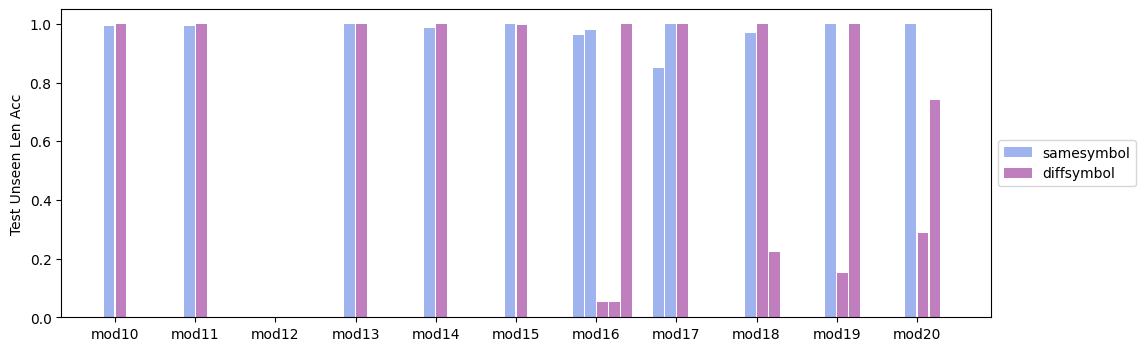

In [ ]:
fig = plt.figure(figsize=(12, 4))

for task in test_unseen_len_acc:
    x = int(task.split("_")[-1].replace("mod", ""))
    shift = shift_mapper[task.split("_")[1]]
    color = color_mapper[task.split("_")[1]]
    for i, t in enumerate(test_unseen_len_acc[task]): 
        plt.bar(
            x+shift*(2*i+1), 
            t[0], 
            width=w*0.9,
            color=color, 
            alpha=0.5,
        )

for k in color_mapper:
    plt.bar(x, 0, label=k, color=color_mapper[k], alpha=0.5)
plt.ylabel("Test Unseen Len Acc")
plt.xticks(list(range(10, 21)), [f"mod{i}" for i in range(10, 21)])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Move Infr Files to /data

In [2]:
import os
from tqdm import tqdm

In [3]:
output_dir = "/home/yingshac/workspace/llms_do_math/scripts/causal_transformer/output"
data_output_dir = "/data/yingshac/llms_do_math/scripts/causal_transformer/output"
for h in tqdm(os.listdir(output_dir)):
    folders = ["test_samples", "val_samples"]
    for f in folders:
        if f in os.listdir(f"{output_dir}/{h}"):
            command = f"mv {output_dir}/{h}/{f} {data_output_dir}/{h}/"
            #print(command)
            #os.system(command)

100%|██████████| 348/348 [07:09<00:00,  1.23s/it]


In [7]:
# delete tensorboard
output_dir = "/home/yingshac/workspace/llms_do_math/scripts/causal_transformer/output"
for h in tqdm(os.listdir(output_dir)):
    if "tensorboard" in os.listdir(f"{output_dir}/{h}"):
        command = f"rm -r {output_dir}/{h}/tensorboard"
        #print(command)
        os.system(command)

100%|██████████| 348/348 [00:04<00:00, 82.26it/s] 


In [5]:
command

'rm -r /home/yingshac/workspace/llms_do_math/scripts/causal_transformer/output/0424_235327/tensorboard'

In [6]:
os.system(command)

0

In [1]:
import torch

In [9]:
x = torch.stack([torch.randint(0, 10, (8, 4)) for i in range(2)])
x.size()

torch.Size([2, 8, 4])